In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('./agr_en_train.csv', header = None, usecols=[1,2])
dataset.rename(columns={1:'data', 2:'Category'}, inplace=True)
dataset

,data,Category
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG
...,...,...
11994,They belong to you flight dirty terrorist coun...,OAG
11995,"Really motivating programme, congratulations t...",NAG
11996,fabricated news,OAG
11997,What's wrong with you secular idiots,OAG


In [3]:
## Number of Unique classes in Dataset
dataset.Category.unique()

array(['OAG', 'NAG', 'CAG'], dtype=object)

In [4]:
dataset[['Category']].value_counts().sort_values(ascending=False).plot(kind='bar')

In [5]:
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']

In [6]:
import re
dataset = dataset.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[0-9#+_]')
STOPWORDS = set(stop_words)

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [7]:
dataset['data'] = dataset['data'].apply(clean_text)

In [8]:
dataset['data']

0        well said sonu..you courage stand dadagiri mus...
1        private banks atm's like hdfc icici etc cash. ...
2                           question pakistan adhere this?
3        pakistan comprised fake muslims know meaning u...
4        ??we r cow slaughter course stop leather manuf...
                               ...                        
11994    belong flight dirty terrorist country india .....
11995    really motivating programme congratulations cn...
11996                                      fabricated news
11997                          what's wrong secular idiots
11998    looks like inevitable political hard ball dial...
Name: data, Length: 11999, dtype: object

In [24]:
import warnings
warnings.filterwarnings('ignore')
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50_000 # 192986
# Max number of words in each news.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100

import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer() #only most frequent words will be returned.
corpus = dataset['data'].to_list()
tokenizer.fit_on_texts(corpus) #creates the vocabulary index based on word frequency
word_index = tokenizer.word_index
#tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
print('Found %s unique tokens.' % len(word_index))

Found 22425 unique tokens.


In [25]:
X = tokenizer.texts_to_sequences(dataset['data'].values)

from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (11999, 500)


In [26]:
Y = pd.get_dummies(dataset['Category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (11999, 3)


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8399, 500) (8399, 3)
(3600, 500) (3600, 3)


In [28]:
X.shape[1]

500

In [29]:
from keras.models import Sequential
from keras import layers
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras import backend as K
from keras.layers import Embedding
import warnings
warnings.filterwarnings('ignore')

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

history = model.fit(X_train, Y_train, epochs=5,validation_data=(X_test, Y_test))

Train on 8399 samples, validate on 3600 samples
Epoch 1/5
8399/8399 [==============================] - 335s 40ms/step - loss: 1.0141 - acc: 0.4587 - val_loss: 0.9264 - val_acc: 0.5486
Epoch 2/5
8399/8399 [==============================] - 330s 39ms/step - loss: 0.7537 - acc: 0.6725 - val_loss: 0.9578 - val_acc: 0.5475
Epoch 3/5
8399/8399 [==============================] - 326s 39ms/step - loss: 0.4926 - acc: 0.8074 - val_loss: 1.1041 - val_acc: 0.5389
Epoch 4/5
8399/8399 [==============================] - 320s 38ms/step - loss: 0.3004 - acc: 0.8881 - val_loss: 1.4114 - val_acc: 0.5256
Epoch 5/5
8399/8399 [==============================] - 358s 43ms/step - loss: 0.2049 - acc: 0.9278 - val_loss: 1.5750 - val_acc: 0.5164


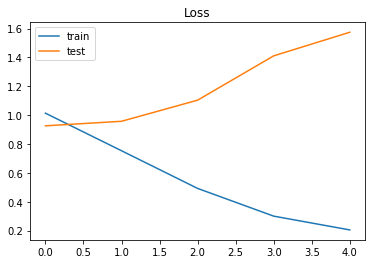

In [30]:
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

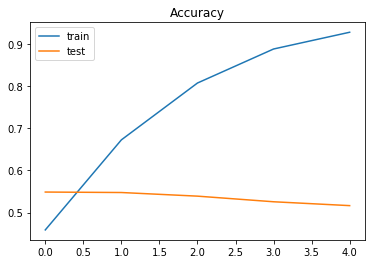

In [31]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [32]:
#new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
testing = ['4 people died and Indian express finds humour in it..rip journalism..'] # Expected : CAG
seq = tokenizer.texts_to_sequences(testing)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

labels = ['OAG', 'NAG', 'CAG']
print(pred, labels[np.argmax(pred)])

[[9.994393e-01 1.771838e-04 3.835351e-04]] OAG
